In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
import keras.layers as klayers
import keras.models as kmodel
import keras.callbacks as kcallbacks

Using TensorFlow backend.


In [2]:
df = pd.read_csv('datasets/PRSA_data_2010.1.1-2014.12.31.csv')
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime( 
    year=row['year'], month=row['month'], day=row['day'], hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1, 1))

In [4]:
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
df_val.reset_index(drop=True, inplace=True)

In [5]:
def makeXy(ts, nb_timesteps):
    """
    Input:
        s: original time series
        nb_timesteps: number of time steps in the regressors
    Output:
        X: 2-D array of regressors
        y: 1-D array of target
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        piece = ts.loc[i-nb_timesteps:i-1]
        X.append(list(piece))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [6]:
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
X_val, y_val = makeXy(df_val['scaled_PRES'], 7)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [8]:
input_layer = klayers.Input(shape=(7,1), dtype='float32')
zeropadding_layer = klayers.convolutional.ZeroPadding1D(padding=1)(input_layer)
conv1D_layer = klayers.convolutional.Conv1D(64, 3, strides=1, use_bias=True)(zeropadding_layer)
avgpooling_layer = klayers.pooling.AveragePooling1D(pool_size=3, strides=1)(conv1D_layer)
flatten_layer = klayers.Flatten()(avgpooling_layer)
dropout_layer = klayers.Dropout(0.2)(flatten_layer)
output_layer = klayers.Dense(1, activation='linear')(dropout_layer)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
ts_model = kmodel.Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 9, 1)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 64)             256       
_________________________________________________________________
average_pooling1d_2 (Average (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 321       
Total para

In [10]:
save_weights_at = os.path.join('keras_models', 'PRSA_data_Air_Pressure_1DConv_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = kcallbacks.ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 4s 102us/step - loss: 0.0285 - val_loss: 0.0341
Epoch 2/20
35057/35057 [==============================] - 3s 91us/step - loss: 0.0175 - val_loss: 0.0113
Epoch 3/20
35057/35057 [==============================] - 4s 103us/step - loss: 0.0158 - val_loss: 0.0102
Epoch 4/20
35057/35057 [==============================] - 4s 100us/step - loss: 0.0144 - val_loss: 0.0097
Epoch 5/20
35057/35057 [==============================] - 3s 95us/step - loss: 0.0142 - val_loss: 0.0145
Epoch 6/20
35057/35057 [==============================] - 3s 99us/step - loss: 0.0137 - val_loss: 0.0109
Epoch 7/20
35057/35057 [==============================] - 4s 103us/step - loss: 0.0138 - val_loss: 0.0138
Epoch 8/20
35057/35057 [==============================] - 3s 92us/step - loss: 0.0135 - val_loss: 0.0108
Epoch 9/20
35057/35057 [==============================] - 3

In [11]:
best_model = kmodel.load_model(os.path.join('keras_models','PRSA_data_Air_Pressure_1DConv_weights.04-0.0097.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

Text(0.5, 0, 'Index')

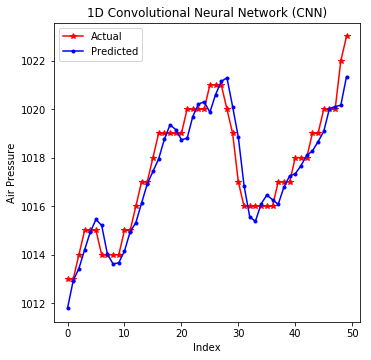

In [12]:
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['PRES'].iloc[7:57], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('1D Convolutional Neural Network (CNN)')
plt.ylabel('Air Pressure')
plt.xlabel('Index')